# `XGBoost`

<div class="alert alert-info">

    
`XGBoost` разрабатывался как исследовательский проект Вашингтонского Университета. Tianqi Chen и Carlos Guestrin представили их работу на конференции SIGKDD в 2016 году и произвели фурор в мире машинного обучения. С момента его введения этот алгоритм не только лидировал в соревнованиях на `Kaggle`, но и был основой нескольких отраслевых приложений.

## **Некоторые фишки:**

* Много параметров регуляризации (`lambda`/`gamma`/`alpha`)
* Считается самым быстрым и менее ресурсозатратным по сравнению с другими бустингами (холиварное утверждение)
* Встроенная работа с пропусками и категориальными признаками (просто `one-hot encoding` ) (`enable_categorical = True` /  `df[cat_col].astype('category')`)
* Поддержка метрик из библиотеки **scikit-learn** в качестве кастомных из коробки.

* Поддержка работы с `Dask` и `Spark` из коробки.
* Поддерживает работу с популярными облачными сервисами и распределенное обучение на кластере или нескольких машинах.
* Поддерживает большинство популярных языков программирования
* Поддерживается другими фреймворками и сервисами (**Optuna**, **Weights & Biases** и пр.)

<div class="alert alert-info">
    
**Особенности реализации бустинга (см. картинку):**
    
* **Параллелизация:** В `XGBoost` построение деревьев основано на параллелизации. Это возможно благодаря взаимозаменяемой природе циклов, используемых для построения базы для обучения: внешний цикл перечисляет листья деревьев, внутренний цикл вычисляет признаки. Нахождение цикла внутри другого мешает параллелизировать алгоритм, так как внешний цикл не может начать своё выполнение, если внутренний ещё не закончил свою работу. Поэтому, для улучшения времени работы, порядок циклов меняется: инициализация проходит при считывании данных, затем выполняется сортировка, использующая параллельные потоки. Эта замена улучшает производительность алгоритма, распределяя вычисления по потокам.
* **Отсечение ветвей дерева** (`gamma`): В фреймворке `GBM` критерий остановки для разбиения дерева зависит от критерия отрицательной потери в точке разбиения. `XGBoost` использует параметр максимальной глубины `max_depth` вместо этого критерия и начинает обратное отсечение. Этот “глубинный” подход значительно улучшает вычислительную производительность.
* **Аппаратная оптимизация:** Алгоритм был разработан таким образом, чтобы он оптимально использовал аппаратные ресурсы. Это достигается путём создания внутренних буферов в каждом потоке для хранения статистики градиента.
* **Регуляризация:** Он штрафует сложные модели, используя как регуляризацию `LASSO` (L1), так и `Ridge`-регуляризацию (L2), для того, чтобы избежать переобучения.
* **Работа с пропусками:** Алгоритм упрощает работу с разреженными данными, в процессе обучения заполняя пропущенные значения в зависимости от значения потерь.
* **Кросс-валидация:** Алгоритм использует свой собственный метод кросс-валидации на каждой итерации.

<div class="alert alert-info">

Во многом `XGBoost` похож на `LightGBM` (с точки зрения пользователя): также создается объект `booster`, есть отдельное **sklearn API**, алгоритм `dart`, `callbacks`, `scheduler` и пр. Но есть и некоторые особенности. Давайте посмотрим на них.

In [1]:
!pip install xgboost -q

In [2]:
import xgboost as xgb

import numpy as np
import pandas as pd

import warnings; warnings.filterwarnings("ignore")

In [3]:
# Загружаем train-датасет который мы сохранили на шаге quickstart
train = pd.read_csv('quickstart_train.csv')
train.head(3)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,109.99,another_bug,4.737759,1.214131e+07,0.1,180.855726,0.023174,174,170
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,34.48,electro_bug,4.480517,1.803909e+07,0.0,187.862734,12.306011,174,174
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,34.93,gear_stick,4.768391,1.588366e+07,0.1,102.382857,2.513319,174,173


In [4]:
drop_cols = ['car_id', 'target_reg', 'target_class']
cat_cols = ['car_type', 'fuel_type', 'model']

X = train.drop(drop_cols, axis=1)
y = train['target_reg']

##  `DMatrix` для предобработки данных

<p id="c1"></p>

* `CatBoost` -> `Pool`
* `LightGBM` -> `Dataset`
* `XGBoost` -> `DMatrix`

<div class="alert alert-info">
    
Класс `DMatrix` предназначен для создания структуры данных, которая используется в `XGBoost`. Структура оптимизирована как по занимаемой памяти, так и по скорости обучения. Принимает множество источников данных. Также стоит отметить параметр `missing`, который позволяет задать значение, которым заменяются пропуски на лету.<br>
Посмотрим на основные параметры и те, которые не встречаются в других бустингах:
* `data` - данные для обучения
* `label` - таргет
* `nthread` - количество параллельных потоков при загрузке данных (`-1` означает все потоки)
* `missing` (по умолчанию `np.nan`) - можно указать значение, которым заменить пропуски.
* `enable_categorical` - сам определит категориальные фичи, если они были предварительно переведены в тип `category` для `pandas.DataFrame`.* <br>
* Как и в `LightGBM`, кат. фичи из строк надо предварительно перевести к целочисленному типу, т.е. провести `label-encoding`.<br>

* Также имеет полезный метод `save_binary(fname, silent=True)` - позволяет сохранить датасет в бинарном формате и экономить память и время при дальнейших экспериментах. <br>
* ⚠️ Из интересного, стоит отметить отдельный класс `QuantileDMatrix`, который генерирует квантилизованный датасет прямо из источника данных, что позволяет экономить память, избегая промежуточного хранения данных. У этого класса появляются дополнительные параметры:
* `max_bin` - контролирует количество бинов при квантилизации (должно соответствовать параметру `max_bin` модели)
* `ref` - в случае создания валидационного датасета, в параметр передается ссылка на трэйн датасет (другой `QuantileDMatrix`), чтобы получить из него информацию о квантилях и избежать потери данных.

In [5]:
from sklearn.model_selection import train_test_split

# Кат фичи преведем в тип 'category'
for col in cat_cols:
    X[col] = X[col].astype('category')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
dtrain = xgb.DMatrix(X_train,
                     label=y_train,
                     nthread=-1,
                     enable_categorical=True,)

dtest = xgb.DMatrix(X_test,
                    y_test,
                    nthread=-1,
                    enable_categorical=True)

## Как и в `LightGBM`, здесь представлено 2 основных способа обучения модели:

<p id="c2"></p>

<div class="alert alert-info">

* Автонономный метод `train`
* Классический sklearn-API с `fit()`, `predict()`

Также реализованы dask-API (`dask.train()`) и spark-API (`spark.SparkXGBRegressor`, например)<br>
И отдельные классы для обучения `Random Forest` (например, `xgboost.XGBRFRegressor`)

## 📦 **Способ 1:** В `train()` подается словарь параметров, датасеты, количество итераций.

In [7]:
params = {
    'objective': 'reg:squarederror',
    'tree_method': 'hist', # 'gpu_hist' # Место для ускорения
    'seed': 42,
}
booster = xgb.train(params,
                    dtrain=dtrain,
                    num_boost_round=30,
                    evals=[(dtrain, 'dtrain'), (dtest, 'dtest')],
                    early_stopping_rounds=10,
                    verbose_eval=5)

[0]	dtrain-rmse:14.51967	dtest-rmse:15.73818
[5]	dtrain-rmse:9.49716	dtest-rmse:12.65256
[10]	dtrain-rmse:7.94051	dtest-rmse:12.71816
[15]	dtrain-rmse:7.23939	dtest-rmse:12.75195
[18]	dtrain-rmse:6.55863	dtest-rmse:12.88637


<div class="alert alert-info">

В методе `predict`, всех ранее рассмотренных бустингов, есть параметр, отвечающий за количество деревьев, используемых для прогноза - бывает полезно, если нет валидационного датасета или для проверки утечек (data leaks) в валидационном датасете - отправлять на лидерборд прогноз модели с меньшим или большим количеством деревьев относительно лучшей итерации. В `XGBoost`, это параметр `iteration_range`.

In [8]:
# инференс
from sklearn.metrics import mean_squared_error

y_pred = booster.predict(dtest,
                         iteration_range=(0, booster.best_iteration + 1))
mean_squared_error(y_test, y_pred) ** 0.5

12.621295288019933

Опцию с `iteration_range` полезно использовать для имитации `early_stopping_rounds` у обученных бустингов в режимах `dart`, где нет ранней остановки. 

**Методы 📥 сохранения и 📤 импорта тоже есть** 

In [9]:
# сохранение модели
booster.save_model('xgb_0001.json')

In [10]:
# Load model
bst = xgb.Booster({'nthread': 4})
bst.load_model('xgb_0001.json')

In [11]:
y_pred = bst.predict(dtest)
mean_squared_error(y_test, y_pred) ** 0.5

12.88636633819062

**Посмотрим на feature importance**

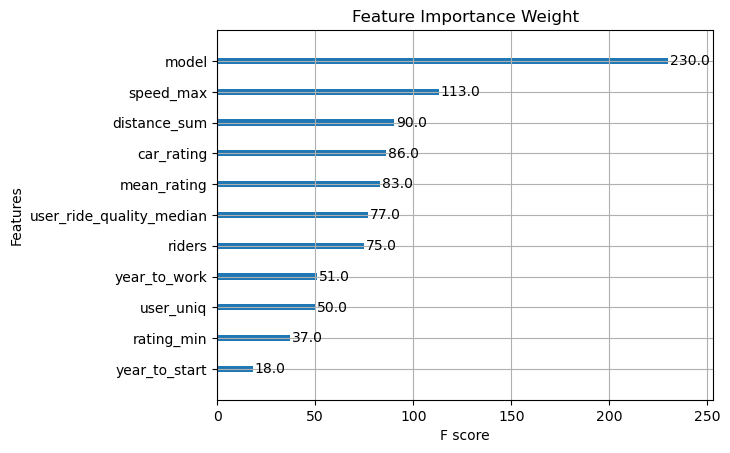

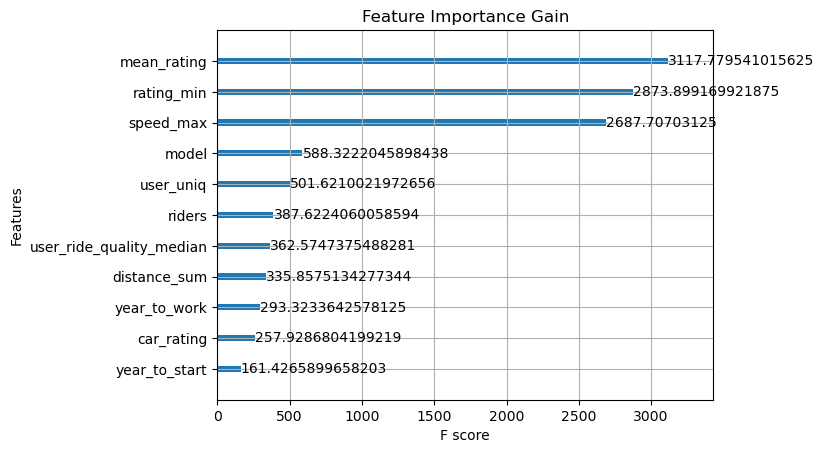

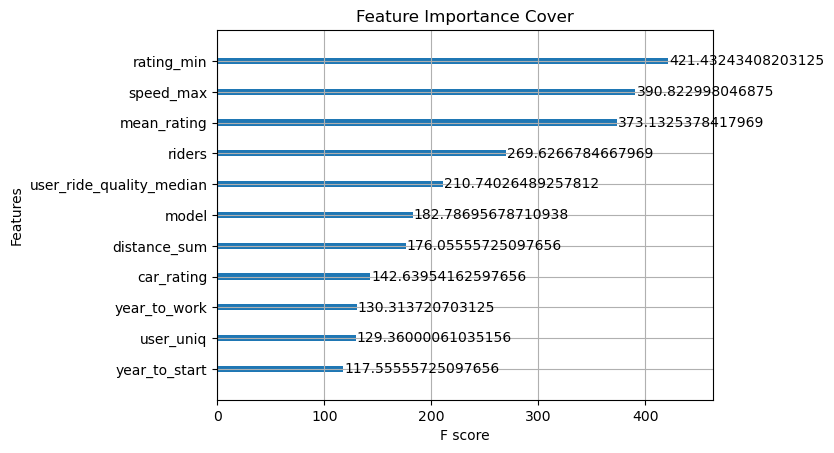

In [12]:
# ”weight” is the number of times a feature appears in a tree
# ”gain” is the average gain of splits which use the feature
# ”cover” is the average coverage of splits which use the feature where overage is defined as the number of samples affected by the split

xgb.plot_importance(bst, title='Feature Importance Weight')
xgb.plot_importance(bst, importance_type='gain', title='Feature Importance Gain')
xgb.plot_importance(bst, importance_type='cover', title='Feature Importance Cover');

## 📦 **Способ 2:** через `Scikit-Learn` API

In [13]:
reg = xgb.XGBRegressor(tree_method="hist",
                       enable_categorical=True,
                       use_rmm = True)

# fit() не принимает DMatrix
reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [14]:
# reg.set_param({"predictor": "gpu_predictor"}) # cpu_predictor
y_pred = reg.predict(X_test)

In [15]:
print(mean_squared_error(y_test, y_pred) ** 0.5)

# В отличие от LightGBM, не нужно получать объект booster перед сохранением
reg.save_model("xgb_regressor.json")
reg.load_model("xgb_regressor.json")
y_pred = reg.predict(X_test)
print(mean_squared_error(y_test, y_pred) ** 0.5)

13.404463678084706
13.404463678084706


<div class="alert alert-info">
    
Более удобный, если вы настраиваете `K-Fold` валидацию сами

# 🚸 Важные [гиперпараметры](https://xgboost.readthedocs.io/en/stable/parameter.html) модели.

## Основные параметры

<p id="c3"></p>

<div class="alert alert-info">

* `booster` (default=`gbtree`)
  * `gbtree` - градиентный бустинг над деревьями
  * `dart` - градиентный бустинг над деревьями с отбрасыванием части данных (`dropout`) - уже знакомо по `LightGBM`
  * `gblinear` - регуляризованный градиентный бустинг c регуляризациями l1 и l2 (работает только с `DMatrix`) - что-то новенькое

* `verbosity` (default=1) - режим вывода сообщений при обучении 0 (silent), 1 (warning), 2 (info), 3 (debug)
* `verbose_eval` (default=1, в sklearn API: `verbose`) - частота вывода сообщений о процессе обучения (1 - каждую итерацию, 5 - каждую 5-ю и.т.д.)
* `nthread` (default=-1 максимально возможное число потоков, в sklearn API: `n_jobs`) - число ядер процессора, задействованных при обучении
*  ⚠️ `use_rmm` - Использовать ли диспетчер памяти RAPIDS (RMM) для выделения памяти графического процессора. Этот параметр применим только тогда, когда `XGBoost` собран (скомпилирован) с включенным подключаемым модулем RMM. Допустимые значения: True и False.

<div class="alert alert-info">

## Что там по `GPU` ?!
    
* `tree_method` (default='auto') - `'hist'` или `'gpu_hist'`, учим на процессоре или на GPU
  * `auto`: эвристический подбор самого быстрого метода.
  * `exact`: `Exact greedy algorithm`. Перебирает всех возможных кандидатов для разделения. (для маленьких датасетов)
  * `approx`: `Approximate greedy algorithm`. Использует квантилизацию и гистограмму градиента. (для больших датасетов)
  * `hist`: `Faster histogram optimized approximate greedy algorithm`. (для больших датасетов с лучшей производительностью)
  * `gpu_hist`: `GPU` имплементация `hist` режима.

## Параметры бустера

* `eta` (default=0.3, aka: `learning_rate`) - шаг обучения
* `max_depth` (default=6) - максимальная глубина дерева. Чем больше глубина, тем сложнее модель и более склонна к оверфиту.
* `num_boosting_rounds` (default=100, в sklearn API `n_estimators`) - количество деревьев(итераций) бустинга.

# <center> 📦 Параметры регуляризации (`alpha`/`lambda`/`gamma`)

<div class="alert alert-info">

* `lambda` (default=1, alias: `reg_lambda`) и `alpha` (default=0, alias: `reg_alpha`) - отвечают за L2 и L1 регуляризации соответственно. Чем больше значение параметров, тем более консервативной (менее склонной к переобучению, но может упускать актуальную информацию) становится модель. Рекомендуемые значения находятся в диапазоне `0–1000` для обоих.
* `gamma` (default=0, aka: `min_split_loss`) - значение минимального изменения лосса для разделения ветви дерева - чем больше `gamma`, тем более консервативной будет модель.

## Еще регуляризация

* `min_child_weight` (default=1) -  Если шаг разделения дерева приводит к листовому узлу с суммой весов экземпляров меньше, чем `min_child_weight`, то процесс построения откажется от дальнейшего разделения. Чем больше `min_child_weight`, тем более консервативной будет модель.
* `subsample` (default=1) - доля экземпляров из обучающей выборки, которая будет использована для построения дерева. 0.5 - берем половину. Обновляется на каждой итерации.
* `colsample_bytree`, `colsample_bylevel`, `colsample_bynode` (default=1) - семейство параметров по отсечению доли признаков на определенном уровне построения дерева.
* `max_bin` (default=256) - максимальное число бинов, на которое может быть разбит числовой признак. Увеличение значения этого параметра может сделать бинаризацию более оптимальной, но увеличит время обучения.

# <center> Параметры `DART` бустера
`dart` - Режим, в котором есть `dropout`, аналогично как в нейронных сетях.

<div class="alert alert-info">

* `rate_drop` (default=0.0) - `Dropout rate` (доля предыдущих деревьев, которые будут отброшены во время `dropout`)
* `one_drop` (default=0) (0 или 1) - когда 1, хотя бы 1 дерево всегда будет отброшено при `dropout`
* `skip_drop` (default=0.0) - вероятность, что `dropout` не будет в течение итерации бустинга (имеет больший приоритет, чем 2 предыдущих параметра) <br>
**⚠️ Если ни один из этих параметров не указать (оставить дефолтные значения), то бустер будет работать в режиме** `gbtree`

⚠️ **Важное замечание:** Использование `predict()` c `DART` бустером. <br>
Если объект бустера относится к типу `DART`, функция `predict()` выполнит отсев (`dropout`), т.е. будут использованы только некоторые деревья. Это приведет к неправильным результатам, если данные не являются обучающей выборкой. Чтобы получить правильные результаты на тестовой выборке, установите `iteration_range` в ненулевое значение <br>

**Например:**  `preds = bst.predict(dtest, iteration_range=(0, num_round))`

🍏 **Интересный факт:** В библиотеке `LightGBM` есть параметр `xgboost_dart_mode` (True или False), видимо у них различные реализации `DART`.
>set this to true, if you want to use xgboost dart mode

# <center> Параметры обучения
<div class="alert alert-info">

`objective` (`default=reg:squarederror`) - лосс-функция. **Определяет задачу, которую вы решаете**
* `reg:squaredlogerror` - квадратичная ошибка
* `reg:logistic` - логистическая регрессия
* `reg:absoluteerror` - абсолютная ошибка
* `binary:logistic` - логистическая регрессия для бинарной классификации - на выходе вероятности
* `binary:logitraw`- то же самое - на выходе "сырые скоры" до применения логистического преобразования
* `multi:softmax` - мультиклассовая классификация
* и много других

`eval_metric` (по дефолту зависит от `objective`) - функция оценки.
* `rmse`, `mae`, `mape` - для регрессии
* `logloss`, `mlogloss` - для классификации
* `auc` и пр.

`seed` (default=0) - фиксирует `random seed`

# <center> 🔧 Тюнинг гиперпараметров модели </center>

### Контроль переобучения
<p id="c4"></p>

<div class="alert alert-info">

В `XGBoost` есть 2 способа борьбы с переобучением:

* Первый - это контроль сложности модели, с помощью параметров:
  * `max_depth` - уменьшить
  * `min_child_weight` - увеличить
  * `gamma` и `lambda` - увеличить

* Второй - это добавить случайность в модель, чтобы сделать её устойчивой к шуму:
  * `subsample` - уменьшить
  * `colsample_bytree`, `colsample_bylevel`, `colsample_bynode` - уменьшить
  * использовать бустер `DART`

## <center> ⏰ `LearningRateScheduler` - изменение `lr` во время обучения </center>
<p id="c5"></p>

<div class="alert alert-info">

* В `XGBoost` представлен отдельный класс `xgboost.callback.LearningRateScheduler(learning_rates)`, который принимает список значений параметра `eta` равный числу итераций обучения.
* Подобно шедулерам, используемым при обучении нейронных сетей, мы можем плавно понижать `learning rate`, ускоряя обучение и не теряя в точности модели.
* Можно экспериментировать с разными сценариями изменений, прогревами и пр.

Посмотрим на примере:

In [16]:
# Создадим список learning rates с помощью функции np.linspace
iters = 30
learning_rates = np.linspace(0.3, 0.005, iters).tolist() # значение lr будет плавно понижаться каждую итерацию с 0.3 до 0.005
scheduler = xgb.callback.LearningRateScheduler(learning_rates)

params = {
    'objective': 'reg:squarederror',
    'tree_method': 'hist',
    'seed': 42,
}
booster = xgb.train(params,
                    dtrain=dtrain,
                    num_boost_round=iters,
                    evals=[(dtrain, 'dtrain'), (dtest, 'dtest')],
                    callbacks=[scheduler], # <------ ✅
                    early_stopping_rounds=10,
                    verbose_eval=5)

y_pred = booster.predict(dtest, iteration_range=(0, booster.best_iteration + 1))
mean_squared_error(y_test, y_pred) ** 0.5

[0]	dtrain-rmse:14.51967	dtest-rmse:15.73818
[5]	dtrain-rmse:9.71674	dtest-rmse:12.75821
[10]	dtrain-rmse:8.30419	dtest-rmse:12.73867
[15]	dtrain-rmse:7.73567	dtest-rmse:12.72774
[16]	dtrain-rmse:7.69031	dtest-rmse:12.73391


12.682673723125248

Видим, что точность модели выросла и `early stopping` не сработал, т.е. точность ещё может вырасти, если продолжить обучение.

## <center> 🍭 Кастомная метрика из `scikit-learn`.</center>

<p id="c6"></p>

<div class="alert alert-info">

В `XGBoost` "из коробки" реализована поддержка метрик из `scikit-learn`, в качестве `eval_metric`, что, несомненно, очень удобно: просто импортируем и используем для тренировки модели.

Также как и в других бустингах, поддерживаются кастом метрики и лоссы - механизм реализации везде примерно одинаковый.

In [17]:
from sklearn.metrics import mean_poisson_deviance

reg = xgb.XGBRegressor(tree_method="hist",
                       eval_metric = mean_poisson_deviance, # <------ ✅
                       enable_categorical=True,
                       n_estimators=30, n_jobs=-1
)
reg.fit(X_train, y_train, 
        eval_set=[(X_test, y_test)],
        early_stopping_rounds=10,
        verbose=3)

[0]	validation_0-rmse:15.73818	validation_0-mean_poisson_deviance:4.83291
[3]	validation_0-rmse:13.04271	validation_0-mean_poisson_deviance:3.25132
[6]	validation_0-rmse:12.64687	validation_0-mean_poisson_deviance:3.07632
[9]	validation_0-rmse:12.65160	validation_0-mean_poisson_deviance:3.07671
[12]	validation_0-rmse:12.67780	validation_0-mean_poisson_deviance:3.08867
[15]	validation_0-rmse:12.75195	validation_0-mean_poisson_deviance:3.13961
[17]	validation_0-rmse:12.83047	validation_0-mean_poisson_deviance:3.17346


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True,
             eval_metric=<function mean_poisson_deviance at 0x7f7f22da4310>,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=30,
             n_jobs=-1, num_parallel_tree=None, random_state=None, ...)

In [18]:
y_pred = reg.predict(X_test, iteration_range=(0, reg.best_iteration + 1))
mean_squared_error(y_test, y_pred) ** 0.5

12.621295288019933

<div class="alert alert-info">

Видим, что `early_stopping` сработал по метрике из `sklearn`. 

В `XGBoost` (как и в `LightGBM`) есть возможность закастомить `early stopping`, чтобы указать по какой именно метрике останавливать обучение.  [Официальный туториал.](https://xgboost.readthedocs.io/en/stable/python/callbacks.html)

# <center> 🧸 Выводы и заключения.

<p id="c7"></p>
<div class="alert alert-info">

* `XGBoost`, во многом похож на `LightGBM`. 
* Из-за отличий в реализации алгоритмов бустинга, может неплохо докидывать в ансамбле. Никогда не знаешь, что выстрелит. 
* Из плюсов: встроенная работа с пропусками, удобная интеграция с `scikit-learn`, интеграция во многие ML-фрэймворки и облачные сервисы.
* Относительно легко ускоряется на `GPU`. 
* Продолжается развиваться и долго еще будет сильным бейзлайном

    